C:\Users\joobzm\AppData\Local\Programs\Python\Python311\Lib\pickle.py:1718: UserWarning: [21:41:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\data\../common/error_msg.h:82: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  setstate(state)
C:\Users\joobzm\Desktop\TDK\ACPI\.venv11\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.5.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limi

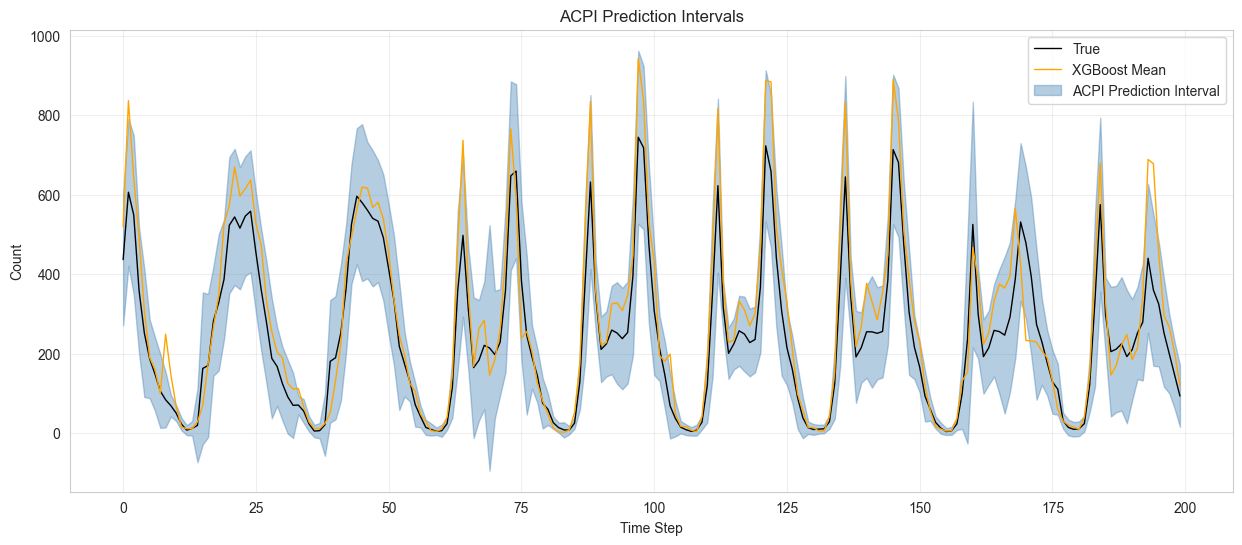

Mean Squared Error: 4562.06
Mean Absolute Error: 44.85
Root Mean Squared Error: 67.54
Mean Absolute Percentage Error: 37.47%
R^2 Score: 0.88
Coverage: 0.94


In [1]:
import numpy as np
import joblib
import xgboost as xgb

from acpi import utils


class XGBoostACPIWrapper:
    """ACPI wrapper for an XGBoost model."""

    def __init__(self, model):
        self.model = model

    def predict(self, X):
        """Predict using the XGBoost model, handling DMatrix conversion."""
        dmatrix = xgb.DMatrix(X)
        return self.model.predict(dmatrix)


# load the acpi model
acpi_model = joblib.load("./models/acpi_xgboost_model_1.pkl")
DATA_TRAIN_PATH = "../data/train.csv"
DATA_TEST_PATH = "../data/test.csv"
target_col = "count"
context_length = 24
train_df = utils.read_bike_data(DATA_TRAIN_PATH)
test_df = utils.read_bike_data(DATA_TEST_PATH)
feature_cols = [c for c in train_df.columns if c != target_col and c in test_df.columns]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_features = scaler.fit_transform(train_df[feature_cols].values.astype(np.float32))
train_target = train_df[target_col].values.astype(np.float32)

# Windowed supervised data
X_all, y_all = utils.build_lag_supervised(train_features, train_target, context_length)

# Time-ordered splits: model train / holdout
train_ratio = 0.8
n_train = int(len(X_all) * train_ratio)
X_test_hold, y_test_hold = X_all[n_train:], y_all[n_train:]

cal_size = 0.5
n_cal = int(len(X_test_hold) * cal_size)
X_test_acpi, y_test_acpi = X_test_hold[n_cal:], y_test_hold[n_cal:]

# Point predictions from the wrapped base model inside ACPI
predictions = acpi_model.model_cali.predict(X_test_acpi)
y_lower, y_upper = acpi_model.predict_pi(X_test_acpi, method='qrf')
utils.plot_acpi_predictions(predictions, y_test_acpi, y_lower, y_upper)
# Evaluate the model
mse = np.mean((predictions - y_test_acpi) ** 2)
mae = np.mean(np.abs(predictions - y_test_acpi))
rmse = np.sqrt(mse)
mape = np.mean(np.abs((predictions - y_test_acpi) / y_test_acpi
                      )) * 100  # Mean Absolute Percentage Error
r2 = 1 - (np.sum((y_test_acpi - predictions) ** 2) / np.sum((y_test_acpi - np.mean(y_test_acpi)) ** 2))
print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Percentage Error: {mape:.2f}%")
print(f"R^2 Score: {r2:.2f}")
# get coverage
coverage = utils.compute_coverage(y_test_acpi, y_lower, y_upper)
print(f"Coverage: {coverage:.2f}")


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SurrogateIntervalNet(nn.Module):
    """
    Differentiable surrogate for ACPI intervals.
    Predicts mu and a non-negative scale via softplus; interval = mu ± z * scale.
    """
    def __init__(self, input_dim: int, z: float, hidden: int = 256, dropout: float = 0.05):
        super().__init__()
        self.z = float(z)
        self.backbone = nn.Sequential(
            nn.Linear(input_dim, hidden), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(hidden, hidden), nn.ReLU(), nn.Dropout(dropout)
        )
        self.mu_head = nn.Linear(hidden, 1)
        self.scale_head = nn.Linear(hidden, 1)  # softplus -> positive

        # Xavier init
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x: torch.Tensor):
        h = self.backbone(x)
        mu = self.mu_head(h).squeeze(-1)
        scale = F.softplus(self.scale_head(h).squeeze(-1)) + 1e-6
        lo = mu - self.z * scale
        hi = mu + self.z * scale
        return mu, lo, hi

In [3]:
import numpy as np
import torch

class GradientCFGenerator:
    """
    Gradient-based CF generator that uses a differentiable surrogate interval model.
    Minimizes: hinge_outside_interval(x) + lambda * ||x - x0||^2 [+ l1].
    Projects into bounds and freezes immutable features after each step.
    """
    def __init__(self, surrogate_model, acpi_model, bounds=None, mutable_idx=None, device=None):
        self.surrogate = surrogate_model
        self.acpi_model = acpi_model
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.surrogate.to(self.device).eval()

        self.bounds = bounds  # (lb, ub) arrays in model input space, or None
        self.mutable_idx = None if mutable_idx is None else np.asarray(list(mutable_idx), dtype=int)

    @torch.no_grad()
    def _project_(self, x_t: torch.Tensor, x0_t: torch.Tensor):
        # Freeze immutable dims
        if self.mutable_idx is not None:
            imm_mask = torch.ones_like(x_t, dtype=torch.bool)
            imm_mask[:] = True
            imm_mask[self.mutable_idx] = False
            x_t[imm_mask] = x0_t[imm_mask]
        # Clip to bounds
        if self.bounds is not None:
            lb, ub = self.bounds
            lb_t = torch.as_tensor(lb, dtype=x_t.dtype, device=x_t.device)
            ub_t = torch.as_tensor(ub, dtype=x_t.dtype, device=x_t.device)
            x_t.clamp_(lb_t, ub_t)
        return x_t

    def generate(
        self,
        x0: np.ndarray,
        y_true: float,
        steps: int = 500,
        lr: float = 0.05,
        lam_l2: float = 0.01,
        lam_l1: float = 0.0,
        kappa: float = 0.0,
        validate_every: int = 10
    ):
        self.surrogate.eval()
        x0 = np.asarray(x0, dtype=np.float32).reshape(-1)
        d = x0.shape[0]

        x = torch.tensor(x0, dtype=torch.float32, device=self.device, requires_grad=True)
        x0_t = torch.tensor(x0, dtype=torch.float32, device=self.device)

        opt = torch.optim.Adam([x], lr=lr)

        best = None
        best_dist = float("inf")

        for t in range(1, steps + 1):
            opt.zero_grad()
            mu, lo, hi = self.surrogate(x.unsqueeze(0))
            mu, lo, hi = mu.squeeze(0), lo.squeeze(0), hi.squeeze(0)

            # Hinge loss to push y_true outside [lo, hi]
            # Two options: push below lo or above hi; take smaller.
            loss_push_down = torch.relu(hi - float(y_true) + kappa)
            loss_push_up = torch.relu(float(y_true) - lo + kappa)
            loss_cf = torch.minimum(loss_push_down, loss_push_up)

            # Proximity terms
            l2 = torch.sum((x - x0_t) ** 2)
            l1 = torch.sum(torch.abs(x - x0_t))
            loss = loss_cf + lam_l2 * l2 + lam_l1 * l1

            loss.backward()

            # Zero gradients on immutable dims
            if self.mutable_idx is not None and x.grad is not None:
                mask = torch.ones(d, device=self.device)
                mask[self.mutable_idx] = 0.0  # keep grads on mutable, zero on immutable
                x.grad = x.grad * (1.0 - mask)

            torch.nn.utils.clip_grad_norm_([x], max_norm=5.0)
            opt.step()

            with torch.no_grad():
                self._project_(x, x0_t)

            # Periodically validate against the real ACPI model
            if (t % validate_every == 0) or (t == steps):
                x_np = x.detach().cpu().numpy().reshape(1, -1)
                y_lo, y_hi = self.acpi_model.predict_pi(x_np)
                uncovered = not (y_lo[0] <= y_true <= y_hi[0])
                if uncovered:
                    dist = float(np.linalg.norm(x_np.reshape(-1) - x0))
                    if dist < best_dist:
                        best = x_np.reshape(-1).copy()
                        best_dist = dist

        if best is None:
            status = "fail_no_counterfactual"
            x_cf = x.detach().cpu().numpy().reshape(-1)
        else:
            status = "success"
            x_cf = best

        # Final metrics
        y_lo_f, y_hi_f = self.acpi_model.predict_pi(x_cf.reshape(1, -1))
        out = {
            "status": status,
            "x_orig": x0,
            "x_cf": x_cf,
            "l2": float(np.linalg.norm(x_cf - x0)),
            "l1": float(np.sum(np.abs(x_cf - x0))),
            "y_true": float(y_true),
            "y_lower_final": float(y_lo_f[0]),
            "y_upper_final": float(y_hi_f[0])
        }
        return out

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def _as_feature_names(base_dim, feature_names=None):
    if feature_names is not None and len(feature_names) == base_dim:
        return list(feature_names)
    return [f"f{j}" for j in range(base_dim)]

def plot_cf_heatmaps(x_orig_row, x_cf_row, context_length, feature_names=None, title_prefix=""):
    x_orig_row = np.asarray(x_orig_row).reshape(-1)
    x_cf_row = np.asarray(x_cf_row).reshape(-1)
    assert x_orig_row.shape == x_cf_row.shape, "Original and CF row must have same shape"
    d = x_orig_row.size

    if d % context_length == 0:
        base_dim = d // context_length
        feats = _as_feature_names(base_dim, feature_names)
        Xo = x_orig_row.reshape(context_length, base_dim)
        Xc = x_cf_row.reshape(context_length, base_dim)
        Xd = Xc - Xo

        fig, axes = plt.subplots(1, 3, figsize=(16, 4), constrained_layout=True)
        sns.heatmap(Xo, ax=axes[0], cmap="viridis")
        axes[0].set_title(f"{title_prefix}Original")
        axes[0].set_xlabel("feature")
        axes[0].set_ylabel("t-lag")
        axes[0].set_xticks(np.arange(base_dim) + 0.5)
        axes[0].set_xticklabels(feats, rotation=90)

        sns.heatmap(Xc, ax=axes[1], cmap="viridis")
        axes[1].set_title(f"{title_prefix}Counterfactual")
        axes[1].set_xlabel("feature")
        axes[1].set_ylabel("t-lag")
        axes[1].set_xticks(np.arange(base_dim) + 0.5)
        axes[1].set_xticklabels(feats, rotation=90)

        v = np.max(np.abs(Xd))
        sns.heatmap(Xd, ax=axes[2], cmap="vlag", center=0, vmin=-v, vmax=v)
        axes[2].set_title(f"{title_prefix}Delta (CF - Orig)")
        axes[2].set_xlabel("feature")
        axes[2].set_ylabel("t-lag")
        axes[2].set_xticks(np.arange(base_dim) + 0.5)
        axes[2].set_xticklabels(feats, rotation=90)
        plt.show()

        # Per-feature aggregate delta (mean |delta| over time)
        agg = np.mean(np.abs(Xd), axis=0)
        plt.figure(figsize=(12, 3))
        plt.bar(np.arange(base_dim), agg)
        plt.title(f"{title_prefix}Mean |delta| per feature")
        plt.xlabel("feature")
        plt.ylabel("mean |delta|")
        plt.xticks(np.arange(base_dim), feats, rotation=90)
        plt.tight_layout()
        plt.show()
    else:
        # Fallback: flat view
        xd = x_cf_row - x_orig_row
        fig, axes = plt.subplots(3, 1, figsize=(14, 6), sharex=True, constrained_layout=True)
        axes[0].plot(x_orig_row, lw=1)
        axes[0].set_title(f"{title_prefix}Original (flat)")
        axes[1].plot(x_cf_row, lw=1)
        axes[1].set_title(f"{title_prefix}Counterfactual (flat)")
        axes[2].plot(xd, lw=1)
        axes[2].axhline(0, color="k", lw=0.5)
        axes[2].set_title(f"{title_prefix}Delta (CF - Orig)")
        axes[2].set_xlabel("dimension")
        plt.show()

[010] train_loss=9030.0470 val_mse(mu,lo,hi)=(4711.1338,4470.5659,7052.1929)
[020] train_loss=3608.2813 val_mse(mu,lo,hi)=(25508.2793,16046.1357,38879.7031)
[030] train_loss=2813.9208 val_mse(mu,lo,hi)=(45855.3086,29482.3184,67185.7031)
[040] train_loss=2546.0720 val_mse(mu,lo,hi)=(62357.9844,38821.2773,92814.6094)
[050] train_loss=2392.6865 val_mse(mu,lo,hi)=(69357.4922,43324.3359,102813.1250)
[060] train_loss=2347.9538 val_mse(mu,lo,hi)=(76498.5547,47090.1797,114431.5547)
Status: success
y_true=520.000, final PI=(170.101, 510.520)
L2 distance: 0.9733


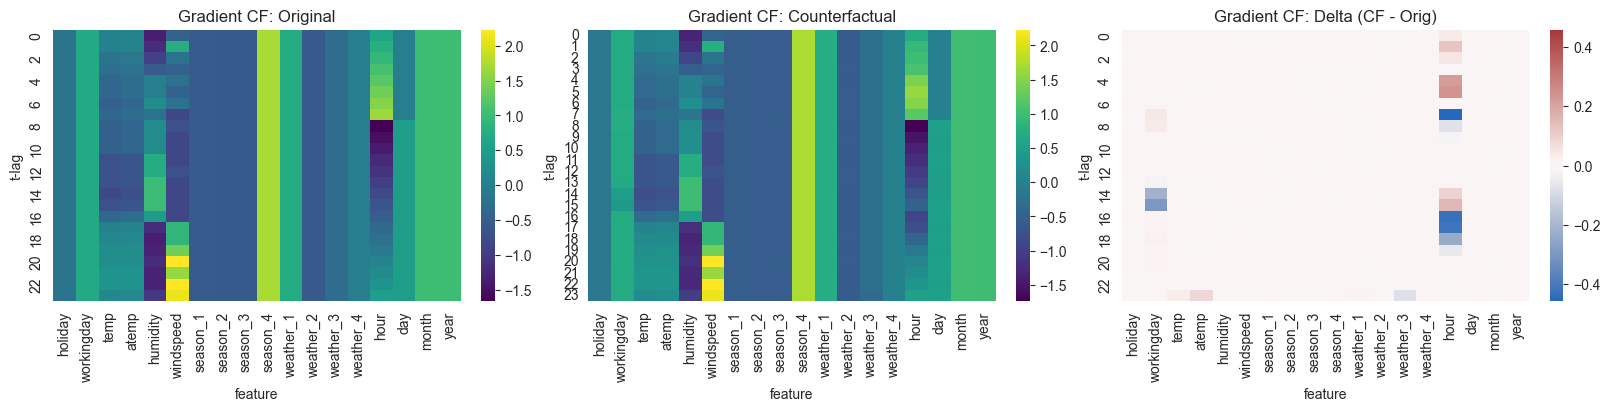

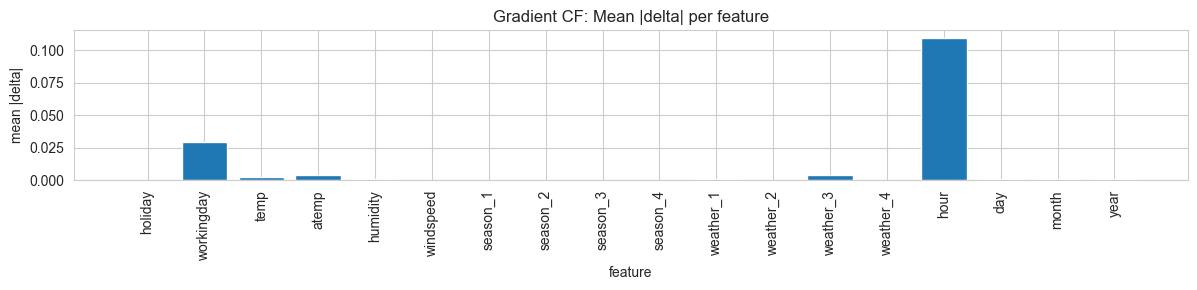

In [6]:
import numpy as np
import torch

def fit_surrogate_interval_net(
    acpi_model,
    X_train: np.ndarray,
    z: float,
    val_split: float = 0.1,
    epochs: int = 50,
    batch_size: int = 256,
    lr: float = 1e-3,
    device=None
):
    """
    Supervise the surrogate to match ACPI: mu ~= point pred, lo/hi ~= predict_pi bounds.
    """
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X_train = np.asarray(X_train, dtype=np.float32)
    n, d = X_train.shape

    # Targets from ACPI
    mu_tgt = acpi_model.model_cali.predict(X_train).astype(np.float32).reshape(-1)
    lo_tgt, hi_tgt = acpi_model.predict_pi(X_train)
    lo_tgt = lo_tgt.astype(np.float32).reshape(-1)
    hi_tgt = hi_tgt.astype(np.float32).reshape(-1)

    # Train/val split
    idx = np.arange(n)
    np.random.shuffle(idx)
    n_val = int(val_split * n)
    val_idx, tr_idx = idx[:n_val], idx[n_val:]

    X_tr, X_val = X_train[tr_idx], X_train[val_idx]
    mu_tr, mu_val = mu_tgt[tr_idx], mu_tgt[val_idx]
    lo_tr, lo_val = lo_tgt[tr_idx], lo_tgt[val_idx]
    hi_tr, hi_val = hi_tgt[tr_idx], hi_tgt[val_idx]

    ds_tr = torch.utils.data.TensorDataset(
        torch.from_numpy(X_tr), torch.from_numpy(mu_tr), torch.from_numpy(lo_tr), torch.from_numpy(hi_tr)
    )
    dl_tr = torch.utils.data.DataLoader(ds_tr, batch_size=batch_size, shuffle=True)

    net = SurrogateIntervalNet(input_dim=d, z=z).to(device)
    opt = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=1e-5)
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=5, factor=0.7)

    def eval_mse(Xv, muv, lov, hiv):
        with torch.no_grad():
            Xt = torch.from_numpy(Xv).to(device)
            mu, lo, hi = net(Xt)
            m = torch.mean((mu - torch.from_numpy(muv).to(device)) ** 2).item()
            l = torch.mean((lo - torch.from_numpy(lov).to(device)) ** 2).item()
            h = torch.mean((hi - torch.from_numpy(hiv).to(device)) ** 2).item()
            return m, l, h

    for ep in range(epochs):
        net.train()
        loss_sum = 0.0
        for xb, mu_b, lo_b, hi_b in dl_tr:
            xb = xb.to(device)
            mu_b = mu_b.to(device)
            lo_b = lo_b.to(device)
            hi_b = hi_b.to(device)

            opt.zero_grad()
            mu_p, lo_p, hi_p = net(xb)
            # Weighted MSE on mu/lo/hi
            loss = (
                torch.mean((mu_p - mu_b) ** 2) * 1.0 +
                torch.mean((lo_p - lo_b) ** 2) * 0.5 +
                torch.mean((hi_p - hi_b) ** 2) * 0.5
            )
            loss.backward()
            torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=5.0)
            opt.step()
            loss_sum += loss.item()

        m, l, h = eval_mse(X_val, mu_val, lo_val, hi_val)
        sched.step(m + l + h)
        if (ep + 1) % 10 == 0:
            print(f"[{ep+1:03d}] train_loss={loss_sum/len(dl_tr):.4f} val_mse(mu,lo,hi)=({m:.4f},{l:.4f},{h:.4f})")
    net.eval()
    return net

# --- Example usage in your notebook context ---

# 1) Build train slice used to fit the surrogate (same space as ACPI inputs)
X_train_acpi = X_all[:n_train]

# 2) Compute z from alpha used by ACPI intervals (alpha=0.1 => z~1.645)
import scipy.stats as _scistats
alpha = 0.1
z = float(_scistats.norm.ppf(1 - alpha / 2.0))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
surrogate = fit_surrogate_interval_net(
    acpi_model=acpi_model,
    X_train=X_train_acpi,
    z=z,
    epochs=60,
    batch_size=512,
    lr=1e-3,
    device=device
)

# 3) Bounds from train percentiles (model input space)
lb = np.percentile(X_train_acpi, 1, axis=0)
ub = np.percentile(X_train_acpi, 99, axis=0)
eps = 1e-6
span = np.maximum(ub - lb, eps)
lb = (lb - 0.05 * span).astype(np.float32)
ub = (ub + 0.05 * span).astype(np.float32)

# 4) Pick a covered instance to explain
y_lo_test, y_hi_test = acpi_model.predict_pi(X_test_acpi)
inside = np.where((y_test_acpi >= y_lo_test) & (y_test_acpi <= y_hi_test))[0]
assert inside.size > 0, "No covered instances found."
idx = int(inside[0])
x0 = X_test_acpi[idx]
y_true = float(y_test_acpi[idx])

# 5) Run gradient-based CF generation
gb_cf = GradientCFGenerator(
    surrogate_model=surrogate,
    acpi_model=acpi_model,
    bounds=(lb, ub),
    mutable_idx=None,
    device=device
)

result = gb_cf.generate(
    x0=x0,
    y_true=y_true,
    steps=600,
    lr=0.05,
    lam_l2=0.01,
    lam_l1=0.0,
    kappa=0.0,
    validate_every=10
)

print(f"Status: {result['status']}")
print(f"y_true={result['y_true']:.3f}, final PI=({result['y_lower_final']:.3f}, {result['y_upper_final']:.3f})")
print(f"L2 distance: {result['l2']:.4f}")

# Optional: visualize with your existing heatmap util if available
try:
    plot_cf_heatmaps(x0, result["x_cf"], context_length=context_length, feature_names=feature_cols, title_prefix="Gradient CF: ")
except Exception as e:
    pass